<style>
    
    h1 {
      display: block;
      max-width: 100%;
      margin-left: auto;
      margin-right: auto;
      text-align: center;
      font-family: "Arial";
      font-size: 32px;
      line-height: 60px;
      font-style: normal;
    }
    
    h2 {
      font-family: "Arial", serif;
      font-size: 24px;
    }

    h3 {
      font-family: "Arial", serif;
      font-size: 20px;
    }

    h4 {
      text-align: center;
      font-size: 20px;
    }

    h5 {
      font-family: "Arial", serif;
      font-size: 16px;
      font-style: oblique;
    }

    div.text_cell_render {
      padding-left: 5%;
      padding-right: 5%;
      width: 90%;
      font-family: "Tahoma", serif;
      font-size: 14px;
    }
    
</style>


<!--
Potential variable values in report include: References as [[2]], Table/Figure numbers as Table 2, formulae with Latex format dollar-sign-enclosed, 
-->

<br>
<div align="center"><h1>Honk sound analysis:</h1></div>
<div align="center"><h4>Visualizing and autocorrelating periodic sound<br>of honking</h4></div>

<br><br>
<h5>Faraz Hossein-Babaei</h5>
<br>

<h2>Introduction</h2>

<p>A periodic honking sound was recorded and analyzed. The idea was to determine the periodicity from the frequency domain on the Fourier Transform of the recorded file data or autocorrelating it after or followed by any tweaking of the data. The method may be extended to examnie properties of recorded music rhythms [[1,2]](#References).

<br><br>

<h2>Method</h2>

<p>Three files containing sound data from 4 recordings, two of periodc honk, human voice, and music. Additionally, a few-second piece of music was synthesized and added to the data with pulses at different audible frequencies. Any multi-channel file would be split into multiple single-channel entries and recombined following the analyses and any manipulation. Fourier transforms of each data package were obtained using the scipy module. Frequency bands selected were used to filter the data, of the result of which inverse Fourier transforms were obtained using scipy.fftpack. The time-domain data before and after filtering as well as the frequency domain data after filtering are plotted in Figures 1-5. The maximum volumes of the files' data were matched.

<br><br>

<h2><b>Results</b></h2>

<h3><b>Fourier Transforms</b></h3>

<p>The discrete transform of the method used outputs an array of as many points/elements as that input. Examining the distinct peaks in the frequency domain of each data array, te transform results appear reasonable, and an inverse Fourier transform on each, without filtering, produced the same sound as the original file's.

<br>

<h3><b>Rhythm</b></h3>

<p>Initially, in the data of each case, any linear trend has to be discarded; otherwise, a large peak in the transform at 0 freuqnecy will be produced. The low frequency portions of the Fourier Transform data were examined (around the 1 Hz scale) to find any peak relating to periodicity pulses containing common frequencies. Integer multiples of such peaks at higher freuqncies as higher harmonics were expected; these were absent and present in different cases. The widths of peaks may give information about how many pulses span each data pack and how exactly periodic the pulses are.

<br><br>

<h2><b>Conclusion</b></h2>

<p>Sound recordings containing periodic features including synthesized music were examined to reveal any periodicity in their features by taking the Fourier Trasnforms of their data. The peaks in the frequency domain plots of the files at the 1 Hz scale revealed the rhythm of the music or honking. The freqnecu domain data was filtered through certain bands that produced, as such, interesting sounds after the inverse Fourier transforms were obtained.

<br><br>

<h2>References</h2>


[[1]] [r1] Faraz.
[r1]: http://farazhb.com

[[2]] [r2] Faraz.
[r2]: http://farazhb.com

<br>


In [1]:
""" Analyzing the periodic honk: Faraz Hossein-Babaei   2017-2-13 ~ 2017-2-29 """

# Module/Function loading:
import numpy as np
from scipy import fft
from scipy.fftpack import ifft
from statsmodels.tsa.tsatools import detrend
import sounddevice as sd
import matplotlib.pyplot as plt
#import matplotlib.gridspec
import re
import time
from scipy.io import wavfile as wav
import IPython.core.display as di
from IPython.core.display import HTML, display, display_html
from IPython.display import Audio

%matplotlib inline
plt.style.use('ggplot')   # style for plots


# Constants:
# Resource files' path and file names
PATH = ("res/mod/", ".wav")
FL_NMS = ("Flute notifi", "Voice 006", "Voice 007", "Voice 008")
MAX_VOL = 30000


In [2]:
""" Hide code segments from nbviewer output """
""" From http://protips.maxmasnick.com/hide-code-when-sharing-ipython-notebooks """
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [3]:
""" Playing sound in html """
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
def wavPlayer(filepath):
    """ will display html 5 player for compatible browser
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play. The browser need to know how to play wav through html5. there is no autoplay to prevent file playing when the browser opens """
    src = """<head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title></head>
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />Your browser does not support the audio element.
    </audio></body>
    """%(filepath)
    #display_html(src)
    display(HTML(src))

In [4]:
""" Reading data """

fl_data = {}
fl_dict = {}
fl_names = [i for i in FL_NMS]


def match_vol (arr):
    #print (np.amax(arr))
    return arr * MAX_VOL/np.amax(arr)

for fl_nm in FL_NMS:
    fl = PATH[0] + fl_nm + PATH[1]
    fl_content = list(wav.read(fl))
    fl_content[1] = match_vol ( fl_content[1].astype(np.float64) )
    
    try:
        nCnl = len(fl_content[1][0])
    except TypeError: nCnl = 1   # in case single channel
    
    if nCnl > 1:   # then split into multiple dict entries, 1 for each channel
        rt = fl_content[0]
        dat = (fl_content[1]).T
        fl_names.remove(fl_nm)
        
        for i in range(nCnl):
            nm = fl_nm + " Ch" + str(i+1)
            fl_dict[nm] = [rt, dat[i]]
            fl_data[nm] = {}
            fl_data[nm]["nCnl"] = nCnl
            fl_names.append(nm)
        continue   # We're already done with the dicts
    
    fl_dict[fl_nm] = fl_content
    fl_data[fl_nm] = {}
    fl_data[fl_nm]["nCnl"] = nCnl


In [5]:
""" Synthesizing and adding the Faraz wave """

# Now, synthesize the Faraz wave
def faraz_sin_lob (A,x,a,b):
    """ a sin wav pulse with lobe btw a,b, amplitude A """
    if a == b: return 0
    if a > b: a,b = b,a
    if x<a or x>b:
        return 0
    else:
        f_part = np.sin(np.pi*(x-a)/(b-a))
        return A * f_part

def faraz_pulse (A,x_arr,a,b):
    """ Complement to faraz_sin_lob to apply it to an array """
    return [faraz_sin_lob(A,x,a,b) for x in x_arr]

new_name = "Faraz"
len_secs, rate_faraz = 10, 44100
# 3 do ~ 6 do, from http://www.liutaiomottola.com/formulae/freqtab.htm
freqs = [130.813,146.832,164.814,174.614,195.998,220,246.942,\
         261.626,293.665,329.628,349.228,391.995,440,493.883,\
         523.251,587.330,659.255,698.456,783.991,880,987.767,1046.502]
faraz_len = len_secs*rate_faraz
x_faraz = np.arange(faraz_len) / rate_faraz
faraz_dat = [0 for i in x_faraz]
for i in range(2*int(len_secs)):
    faraz_dat += MAX_VOL * (np.sin(2*np.pi*freqs[i]*x_faraz) * faraz_pulse(1,x_faraz,i/2,(i+1)/2))
faraz_dat = np.asarray(faraz_dat)
faraz_dat = faraz_dat.astype(np.int16)

fl_dict[new_name] = [rate_faraz, faraz_dat]
fl_data[new_name] = {}
fl_data[new_name]["nCnl"] = 1
fl_names += [new_name]

wav.write ( "res/mod/Faraz.wav", rate_faraz, faraz_dat )


In [6]:
""" FFT, Filtering, and IFFT """

# Filter bands, outside them 0, inside (a,b,c,d) from [c,d) liner modulation by [a,b)
filts = {nm:[] for nm in fl_names}
filts["Voice 006"] = [(1,1,1250,1350)]
filts["Voice 007"] = [(1,1,400,500)]
filts["Voice 008"] = [(1,1,700,850)]
filts["Flute notifi Ch1"] = [(1,1,20,120)]
# filts["Flute notifi Ch1"] = [(1,1,20,360),(1,0.5,360,500),\
#                              (0.5,0.25,500,800),(0.25,0,800,1200)]
filts["Flute notifi Ch2"] = filts["Flute notifi Ch1"]
filts["Faraz"] = [(1,1,10,50),(1,1,100,150),(1,1,200,250),\
                  (1,1,450,500),(1,1,700,750)]


for fl in fl_names:
    # part help: glowingpython.blogspot.ca/2011/08/how-to-plot-frequency-spectrum-with.html
    rate = fl_dict[fl][0]   # [samples/s]
    signal = fl_dict[fl][1]
    signal = detrend ( signal-signal.mean(), order=1 )
    
    n = len(signal)         # [samples]
    T = n / rate            # [seconds]
    smpls = np.arange(n)
    freqs = smpls / T       # [Hz]
    f_trans = fft(signal)
    #print (fl, "n: ",str(n),"  fft length: "+str(len(f_trans)), "  len(freqs): ", str(len(freqs)))
    
    if len(filts[fl]) > 0:
        f_trans_new = [0 for i in range(len(f_trans))]
        rngs = filts[fl]
        for i in rngs:
            i1, i2 =   int(T*i[2]), int(T*i[3])   # see T definition above
            im1, im2 = int(n-1 - T*i[2]), int(n-1 - T*i[3])   # see T definition above
            slp = (i[1]-i[0]) / (i2-i1)
            f_trans_new[i1:i2] =   [f_trans[i1+j]* (i[0]+j* slp) for j in range(i2 -i1 )]
            f_trans_new[im2:im1] = [f_trans[im2+j]*(i[0]+j*-slp) for j in range(im1-im2)]
        f_trans_new = np.asarray(f_trans_new)   # has to be ndarray type to index with range later
    new_signal = ifft(f_trans_new)
    
    fl_data[fl]["rate"] = rate   # a scalar
    fl_data[fl]["length"] = T   # a scalar
    fl_data[fl]["time"] = smpls / rate
    fl_data[fl]["signal"] = signal.astype(np.int16)
    fl_data[fl]["freq"] = freqs
    fl_data[fl]["fft"] = f_trans   # 2-fold, symmetric function
    fl_data[fl]["fft new"] = f_trans_new
    fl_data[fl]["ifft"] = new_signal.real.astype(np.int16)



In [7]:
""" Recombining multi-channel data, and saving files """

multi_ender = re.compile(r"Ch\d+$")   # ending w "Ch"+digits
chNum = re.compile(r"\d+$")   # ending w "Ch"+digits

for fl in fl_names.copy():   # They are ordered, the channels of ay multichannel file
    mMatch = multi_ender.findall(fl)
    nCnl = fl_data[fl]["nCnl"]
    #mMatch = re.findall(multi_ender, fl)
    
    if len(mMatch) == 1:   # i.e. if multiCh. Presumably size can only be 0 or 1
        num = int(chNum.findall(mMatch[0])[0]) - 1   # just extracting the chn num
        origin_nm = fl.replace(mMatch[0], "")[:-1]
        
        if num == 0:
            fl_data[origin_nm] = {}
            fl_names.append(origin_nm)
            #fl_data[origin_nm] = [fl_data[fl]["rate"],[]]   # add multiCh entry
            fl_data[origin_nm]["nCnl"] = fl_data[fl]["nCnl"]
            fl_data[origin_nm]["rate"] = fl_data[fl]["rate"]
            fl_data[origin_nm]["length"] = fl_data[fl]["length"]
            fl_data[origin_nm]["time"] = fl_data[fl]["time"]
            fl_data[origin_nm]["freq"] = fl_data[fl]["freq"]
            fl_data[origin_nm]["signal"] = []#np.ndarray()
            fl_data[origin_nm]["fft"] = []#np.ndarray()
            fl_data[origin_nm]["fft new"] = []#np.ndarray()
            fl_data[origin_nm]["ifft"] = []#np.ndarray()
        
        fl_data[origin_nm]["signal"].append(fl_data[fl]["signal"])
        fl_data[origin_nm]["fft"].append(fl_data[fl]["fft"])
        fl_data[origin_nm]["fft new"].append(fl_data[fl]["fft new"])
        fl_data[origin_nm]["ifft"].append(fl_data[fl]["ifft"])
        fl_data.pop(fl, None)   # remove this entry
        fl_names.remove(fl)   # remove this entry
        
        if num == nCnl-1:   # list->tuple TODO: This isn't necessary
            fl_data[origin_nm]["signal"] = np.asarray(fl_data[origin_nm]["signal"]).T
            fl_data[origin_nm]["fft"] = np.asarray(fl_data[origin_nm]["fft"]).T
            fl_data[origin_nm]["fft new"] = np.asarray(fl_data[origin_nm]["fft new"]).T
            fl_data[origin_nm]["ifft"] = np.asarray(fl_data[origin_nm]["ifft"]).T

for fl in fl_data:
    #     print (i)
    wav.write ( "res/mod/" + fl + " filtered.wav", \
               fl_data[fl]["rate"], fl_data[fl]["ifft"] )
for fl in fl_data:
    adj = "   " if len(fl)<9 else ""
    print (fl+adj, "\tLength: ", "%.1f" % fl_data[fl]["length"], " s")
    Audio ("res/mod/" + fl + ".wav")
    Audio ("res/mod/" + fl + " filtered.wav")
#     wavPlayer ("res/mod/" + fl + ".wav")
#     wavPlayer ("res/mod/" + fl + " filtered.wav")



Voice 008 	Length:  40.3  s
Flute notifi 	Length:  13.0  s
Voice 006 	Length:  15.9  s
Faraz    	Length:  10.0  s
Voice 007 	Length:  32.7  s


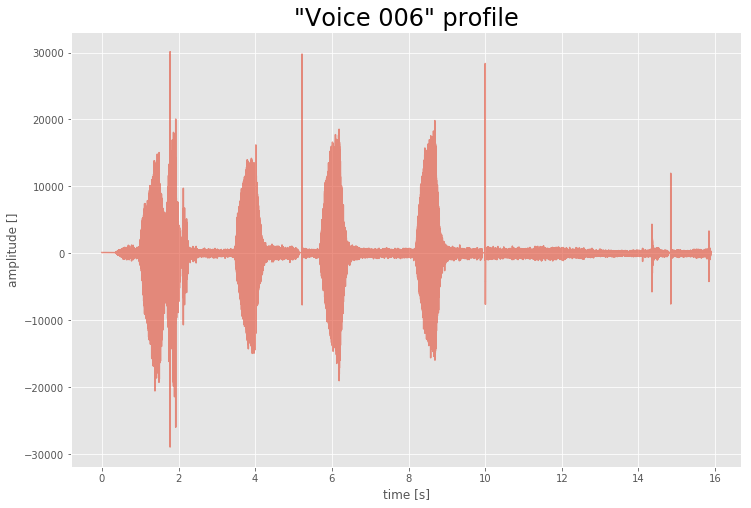

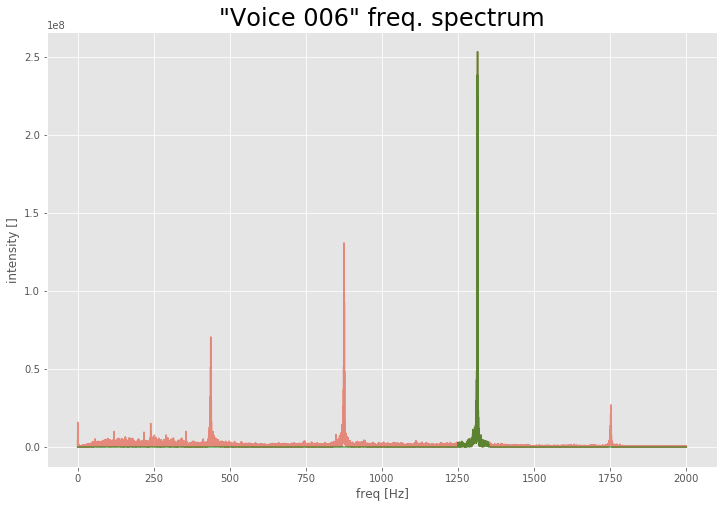

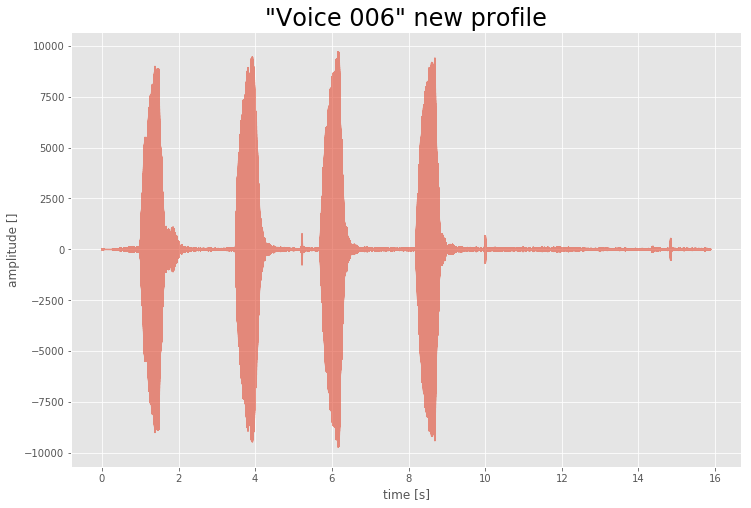

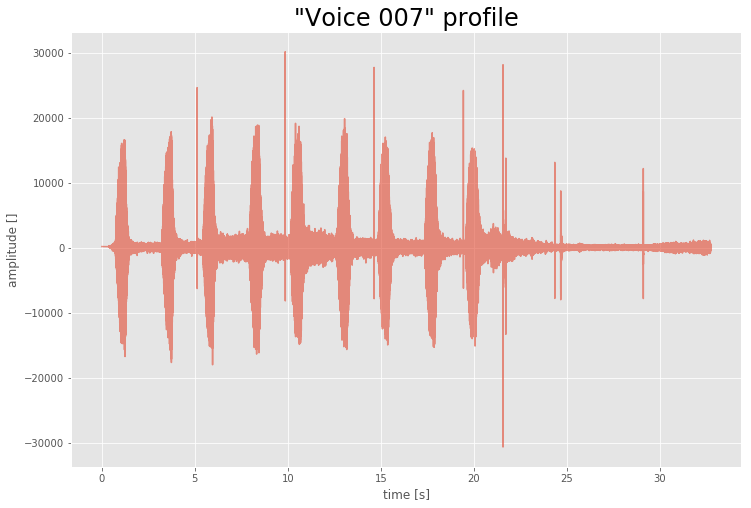

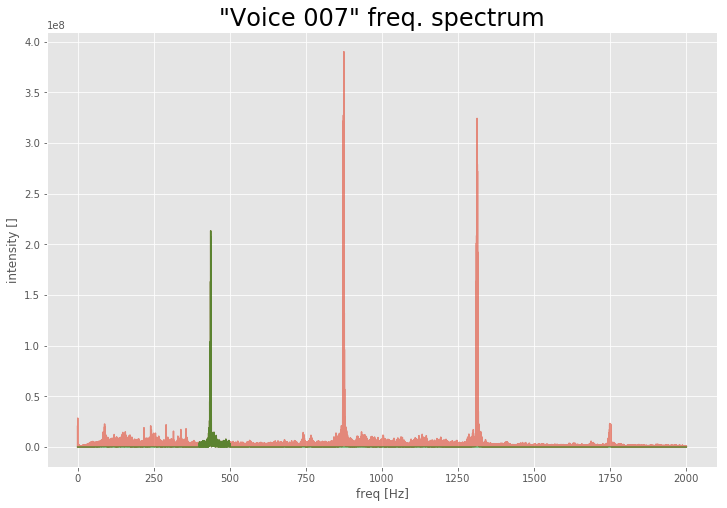

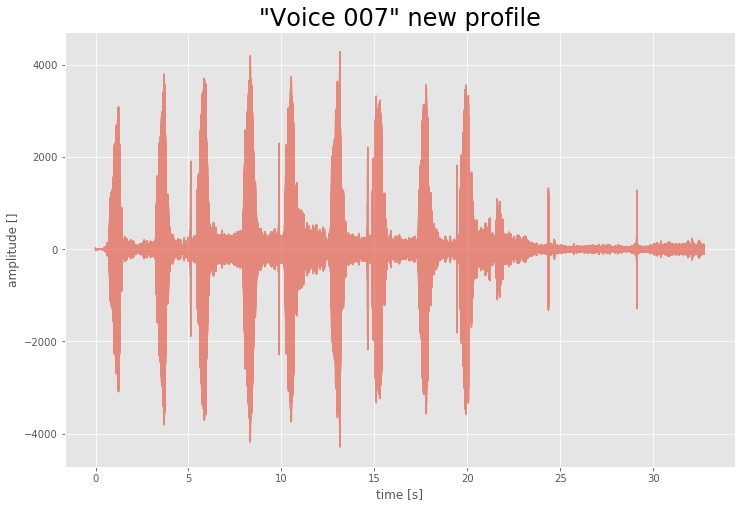

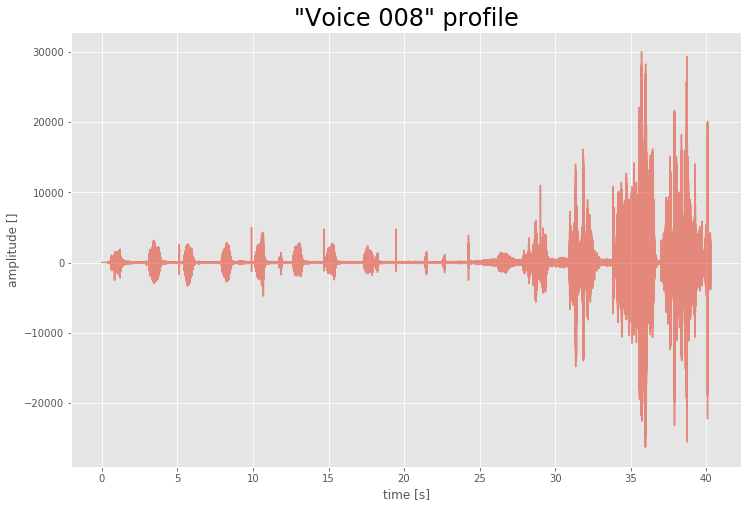

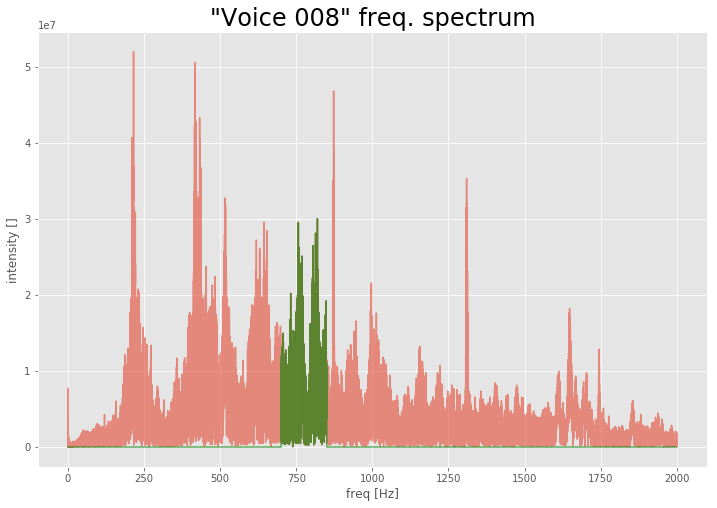

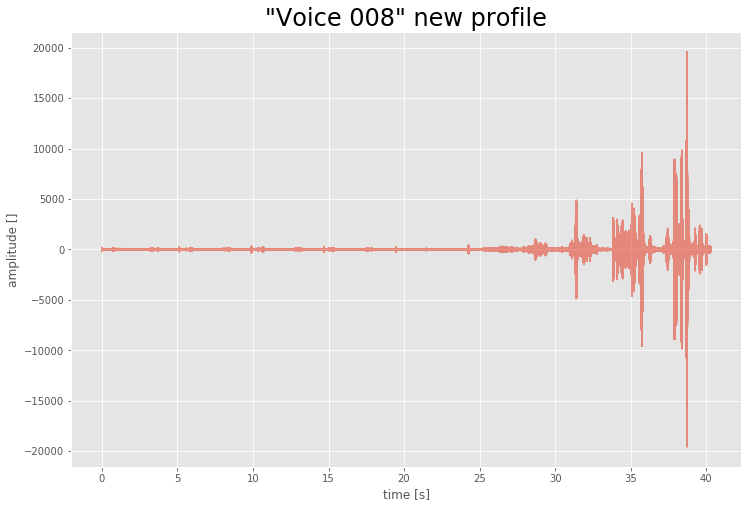

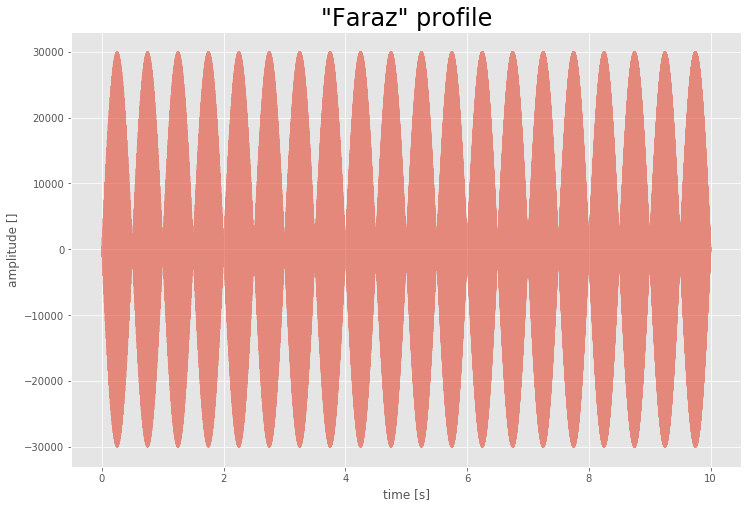

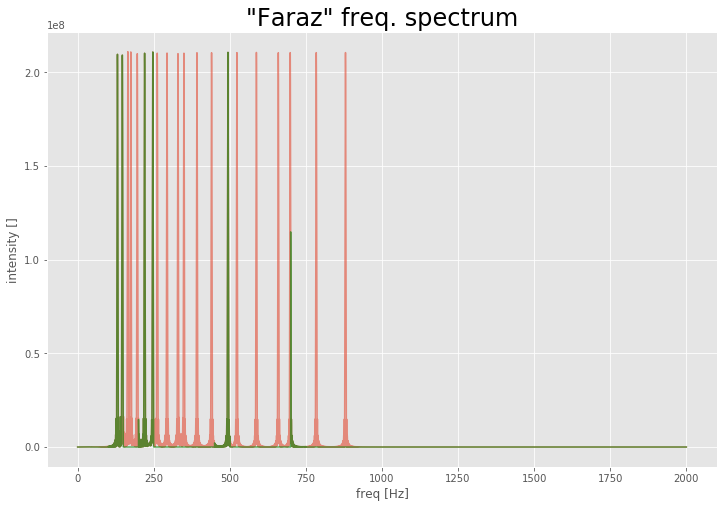

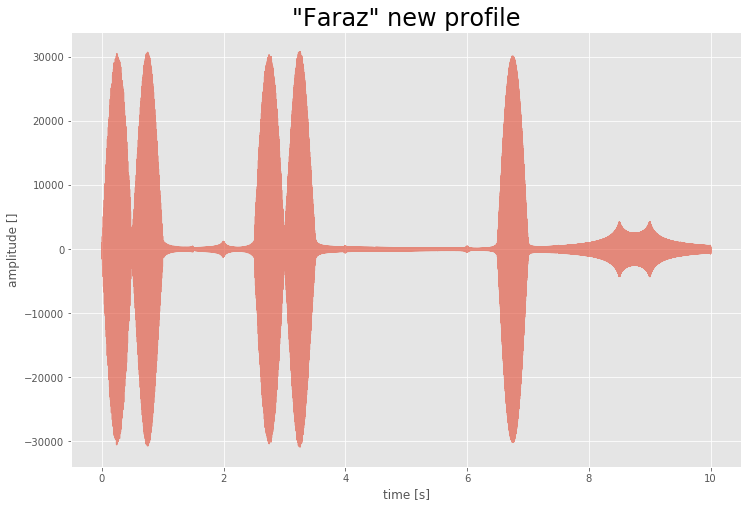

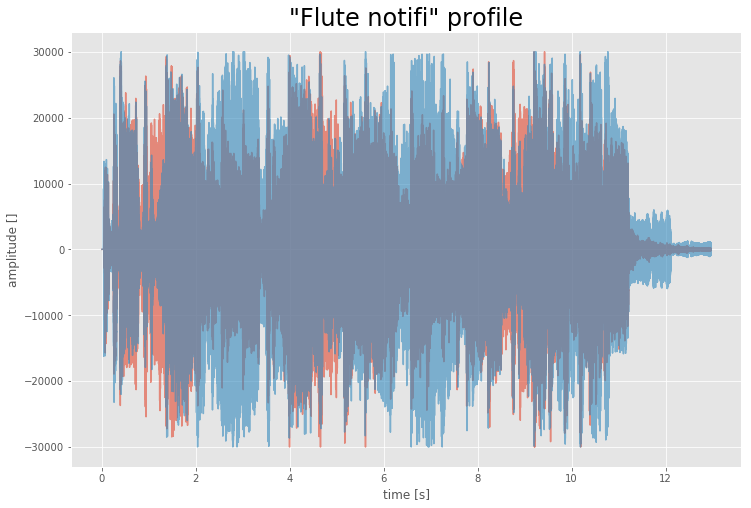

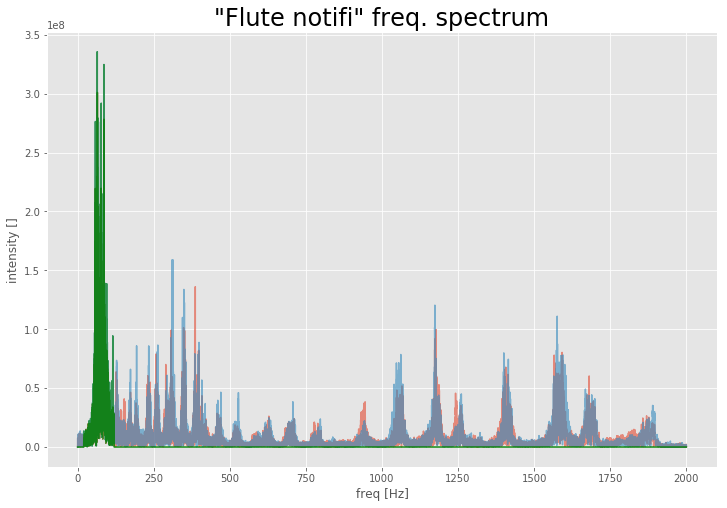

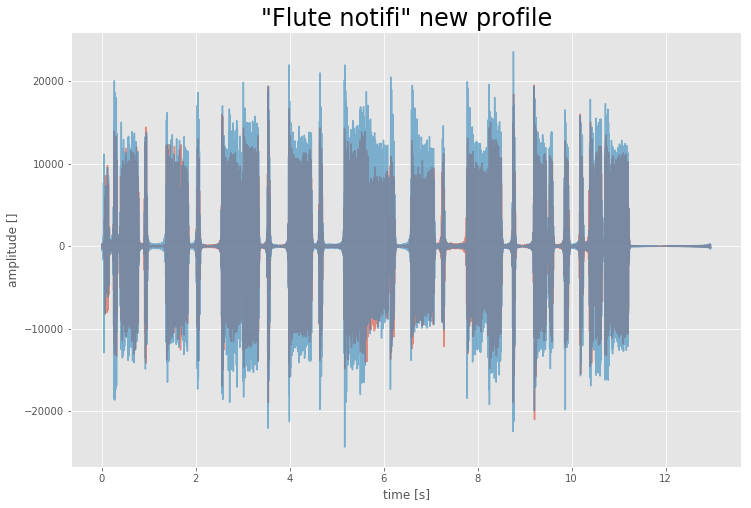

In [8]:
""" Plotting """

def plot_wav (ax, x, y, ttl, xlbl, ylbl, clr=None):
    """ data is the 2nd elem of the wav read data tuple """
    
    if clr:
        ax.plot(x, y, color=clr, alpha=0.6)
    else:
        ax.plot(x, y, alpha=0.6)
    ax.set_title(ttl, fontsize=24)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)



#ta, tb = 70000, 80000   # [s] Use as  [ta*44100:tb*44100]
fa, fb = 0,2000   # [Hz]

for fl in fl_names:
    
    pfa, pfb = int(fa*fl_data[fl]["length"]), int(fb*fl_data[fl]["length"])
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ttl = '"' + fl + '" profile'
    plot_wav (ax, fl_data[fl]["time"], fl_data[fl]["signal"],\
              ttl, "time [s]", "amplitude []")
    plt.show()
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ttl = '"' + fl + '" freq. spectrum'
    plot_wav (ax, fl_data[fl]["freq"][pfa:pfb], abs(fl_data[fl]["fft"][pfa:pfb]),\
              ttl, "freq [Hz]", "intensity []")
    plot_wav (ax, fl_data[fl]["freq"][pfa:pfb], abs(fl_data[fl]["fft new"][pfa:pfb]),\
              ttl, "freq [Hz]", "intensity []", clr='green')
    plt.show()
    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)   # TODO: forget sub. Use gridspec for 5 x 3 (time, freq domain side-by-side)
    ttl = '"' + fl + '" new profile'
    plot_wav (ax, fl_data[fl]["time"], fl_data[fl]["ifft"],\
              ttl, "time [s]", "amplitude []")
    plt.show()



In [9]:
""" Playing sounds """

for fl in ["Flute notifi"]:#fl_names:
    rate = fl_data[fl]["rate"]
    length = fl_data[fl]["length"]

#     sd.play (fl_data[fl]["signal"][:], rate)
#     time.sleep(length + 1)
    sd.play (fl_data[fl]["ifft"][:], rate)
    time.sleep(length + 1)
